<center><h2>DSSP<br>24/01/2020<br>Text Mining using Python<br></h2>G. Nikolentzos, M. Vazirgiannis</center>

The goal of this lab is to work with textual data, applying data mining techniques.  The basic objective
of text mining concerns the discovery and extraction of relevant and valuable information from large
volumes of textual data. More precisely, we will focus on the *opinion mining* problem (also known as *sentiment analysis*), which refers to the use of natural language processing, text analysis and machine learning tools in order to identify and extract subjective information from text corpora.

Our goal is to identify *positive* and *negative* opinions in reviews expressed by natural language (i.e., text) about a specific product. Opinion mining can be useful in several ways.  It can help a company to evaluate the success of an ad campaign or of a new product, determine which versions of a product or service are popular and identify which demographics like or dislike particular product features.

There are several challenges in the problem of opinion mining. The first one concerns the fact that a specific word used to describe a product can be considered either as positive or as negative depending on the context or the product. Let's consider for example a review about a laptop that contains the word "long". If a customer said that the battery life of the laptop was long, that would be a positive opinion. However,  if the customer said that the laptop's start-up time was long, that would be a negative opinion. This example indicates that an opinion mining system, trained to gather opinions on one type of product, may not perform very well on another. A second challenge is that people do not always express their opinions in the same way. Most traditional text mining algorithms rely on the fact that small differences between two pieces of text do not change the meaning very much. However, in opinion mining, "the laptop was great" is very different from "the laptop was not great". Lastly, people can combine contradictory statements in their reviews, where  both positive and negative comments are written in the same sentence. Although this is easy for a human to understand, it is more difficult for a computer to parse.

In the context of this lab, we will analyze reviews about movies (e.g., obtained from  [IMDb](http://www.imdb.com/), an online database of information related to films and television programs). We will follow a text categorization (or classification) approach to infer if a review is positive or negative. To perform classification, we will produce the following three representations of text and we will pass them on to a Logistic Regression classifier: (i) the well-known bag-of-words representation with TF-IDF weighting, (ii) the representation that emerges when we apply Latent Semantic Analysis to the previous representation, and (iii) a representation that consists of features extracted from the graph-of-words representation of text.


Next, we briefly describe the dataset that will be used, and then we present the steps of the pipeline that need to be performed for the sentiment analysis task.

### Dataset Description
The dataset that will be used in the lab consists of movie reviews. As you may have observed, in movie review websites like IMDb, any user can write her own review for a particular movie or television show. For example, the following figure shows the review that a user gave to the movie "Midnight in Paris". As we see, the opinion of this user for the movie is positive.

<img src="figures/imdb_review.png"> 

Here, we will consider such a dataset, where each review has been characterized as *positive* or *negative*. The data is contained in the `movie_reviews.csv` file. The file is composed of 1,959 reviews (one per line) and each one has been characterized as positive or negative. Below you are given a function that loads the data and their labels from the disk.

In [1]:
import csv

def load_file():
    with open('data/movie_reviews.csv', errors='ignore') as csv_file:
        reader = csv.reader(csv_file, delimiter=',',quotechar='"')
        
        # Initialize lists for data and class labels
        data =[]
        labels = []
        # For each row of the csv file
        for row in reader:
            # skip missing data
            if row[0] and row[1]:
                data.append(row[0])
                y_label = -1 if row[1]=='negative' else 1
                labels.append(y_label)
    return data,labels

<ul>Tasks:</ul>
- Use the function defined above to load the data.
- Print the first review of the dataset and its class label. Note that label 1 corresponds to a positive review, while label -1 to a negative review.

In [2]:
data, class_labels = load_file()

print("1st review:", data[0])
print()
print("Class label of 1st review:", class_labels[0])

1st review: This movie is really not all that bad. But then again, this movie genre is right down my alley. Sure, the sets are cheap, but they really did decent with what they had. <br /><br />If you like cheap, futuristic, post-apocalyptic B movies, then you'll love this one!! I sure did!<br /><br />

Class label of 1st review: 1


### Description of the Task and the Pipeline

Our goal is to build a system that, given the review text of a movie, it will be able to predict if the opinion of the user is positive or negative. We will treat the problem as a classification task, where the goal is predict the class label, i.e., positive or negative, for a given review. In what follows, we use the word "document" to refer to text reviews. The outline of the task is given in the following figure.

<img src="figures/outline.png"> 

The pipeline that typically is followed to deal with the problem is similar to the one applied in any classification problem; the goal is to learn the parameters of a classifier from a collection of training documents (i.e., those reviews that we know if they are positive or negative) and then to predict the class of unlabeled documents.  The first step in text categorization is to transform documents, which typically are strings of characters, into a representation suitable for the learning algorithm and the classification task. Here, we will employ the *Vector Space Model*, a spatial representation of text documents. In this model, each document is represented by a vector in a $n$-dimensional space, where each dimension corresponds to a term (i.e., word) from the overall vocabulary of the given document collection. More formally, let $\mathcal{D}=\{d_1, d_2, \ldots, d_m\}$ denote a collection of $m$ documents, and $\mathcal{T}=\{t_1, t_2,\ldots,t_n\}$ be the dictionary, i.e., the set of words in the corpus $\mathcal{D}$. As we will describe later, $\mathcal{T}$ is obtained by applying some standard natural language processing techniques, such as stop words removal and stemming. Each document $d_i \in \mathcal{D}$ is represented as a vector of term weights $d_i=\{w_{i,1}, w_{i,2}, \ldots, w_{i,n}\}$, where $w_{i,k}$ is the weight of term $k$ in document $d_i$. That way, data can be represented by the *Document-Term matrix* of size $m \times n$, where the rows correspond to documents and the columns to the different terms (i.e., features) of set $\mathcal{T}$. Additionally, each document $d_i$ is associated with a class label $y_i=\{+,-\}$ (i.e., positive/negative opinion) forming the class vector $y$, and the goal is to predict the class labels for a set of test documents. Based on this formulation, traditional classification algorithms (e.g., SVMs, Logistic Regression, Random Forests, etc.) can be applied to predict the class label of test documents.

Next, we describe the tasks that need to be performed for each part.

### Data preprocessing

Before applying any learning algorithm to the data, it is necessary to apply some preprocessing tasks as shown below:

1. Remove punctuation marks (e.g. .  ,  ?  :  (  )  [  ]) and transform all characters to lowercase. This can be done using Python's [NLTK](http://www.nltk.org/) library.
2. Remove stop words. These are words that are filtered out before processing any natural language data. This set of words does not offer information about the content of the document and typically corresponds to a set of commonly used words in any language. For example, in the context of a search engine, suppose that your search query is "how to categorize documents". If the search engine tries to find web pages that contain the terms "how", "to", "categorize", "documents", it will find many more pages that contain the terms "how" and "to" than pages that contain information about document categorization. This is happening because the terms "how" and "to" are  commonly used in the English language.
3. The third preprocessing step is the one of [stemming](http://en.wikipedia.org/wiki/Stemming), i.e., the process of reducing the words to their word stem or root. For example, a stemming algorithm reduces the words "fishing", "fished", and "fisher" to the root word, "fish". In this lab, we will use *Porter's* stemmer, contained in the NLTK library.

<ul>Tasks:</ul>
- You are given the following function that is given a list of textual documents and performs data preprocessing. Perform stemming using the implementation of Porter's stemmer contained in NLTK.

In [3]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
print(stemmer.stem('fishing'))

fish


In [4]:
import nltk
from nltk.stem.porter import PorterStemmer
import string

def data_preprocessing(data):
    preprocessed_data = list()
    
    # List of stopwords
    stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
                 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
                 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
                 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now','br']

    stemmer = PorterStemmer()
    
    for doc in data:
    
        # Remove punctuation and lowercase
        punctuation = set(string.punctuation)    
        doc = ''.join([w if w not in punctuation else ' ' for w in doc.lower()])
        
        # Stopword removal
        doc = [w for w in doc.split() if w not in stopwords]  
        
        # Stemming
        
        doc = [stemmer.stem(w) for w in doc]
        
        # Covenrt list of words to one string
        doc = ' '.join(w for w in doc)
        
        preprocessed_data.append(doc)
        
    return preprocessed_data    

<ul>Tasks:</ul>
- Use the function defined above to preprocess the reviews of the dataset.

In [5]:
processed_data = data_preprocessing(data)

print("1st review:", data[0])
print()
print("1st preprocessed revew:", processed_data[0])

1st review: This movie is really not all that bad. But then again, this movie genre is right down my alley. Sure, the sets are cheap, but they really did decent with what they had. <br /><br />If you like cheap, futuristic, post-apocalyptic B movies, then you'll love this one!! I sure did!<br /><br />

1st preprocessed revew: movi realli bad movi genr right alley sure set cheap realli decent like cheap futurist post apocalypt b movi ll love one sure


### Feature extraction and the TF-IDF matrix

After applying the preprocessing step, the text data (i.e., all the possible documents-reviews) should be transformed to a format that will be used in the learning (i.e., classification) task. As we describe above, the data will be represented by the Document-Term matrix, where the rows correspond to the different documents of the collection (i.e. reviews) and the columns to the features, which in our case are the different terms (i.e., words). Here, we are interested to find relevant weighting criteria for the Document-Term matrix, i.e., assign a relevance score $w_{ij}$ to each term $t_j$ for each document $d_i$ as shown in the next figure.

<img src='figures/tfidf_matrix.png'>

We will consider the *bag-of-words* representation of the documents. In this case, the importance of a term $t \in \mathcal{T}$ within a document $d \in \mathcal{D}$ is based on the frequency $tf(t,d)$ of the term in the document (TF). Furthermore, terms that occur frequently in one document but rarely in the rest of the documents, are more likely to be relevant to the topic of the document. This is known as the inverse document frequency (IDF) factor, and is computed at the collection level. It is obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient, as follows:

$$ idf(t, \mathcal{D}) = \log \frac{m}{| \{d \in \mathcal{D} : t \in d |\} } $$

where $m$ is the total number of documents in collection $\mathcal{D}$, and the denominator captures the number of documents that term $t$ appears. Having computed the TF and IDF metrics, we can combine them to get the TF-IDF score:

$$ tf\text{-}idf(t,d,\mathcal{D}) = tf(t,d) \times idf(t, \mathcal{D}) $$

This function captures the intuitions that (i) the more often a term occurs in a document, the more it is representative of its content, and (ii) the more documents a term occurs in, the less discriminating it is. Using the TF-IDF score of each term for each document, we can fill in the weights $w_{ij}$ of the Document-Term matrix (see figure above).

<ul>Tasks:</ul>
- Costruct the TF-IDF matrix of the dataset. Use the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>`TfidfVectorizer`</a> object provided by the scikit-learn library.
- Examine the size and the sparsity of this matrix (i.e., fraction of non-zero elements). What do you observe?

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vec = TfidfVectorizer()
X = vec.fit_transform(processed_data)
print(X.shape)
print("Sparsity:", 1-X.size/(X.shape[0]*X.shape[1]))

(1959, 17376)
Sparsity: 0.9945329237866126


### Model learning and prediction

After creating the TF-IDF matrix, the problem has been transformed to a typical classification task: the rows of the matrix correspond to the instances (i.e. reviews) and the columns to the features (i.e. terms). Recall that, for each document we also have class information, i.e. positive or negative review, contained in the `class_labels` list (this list was created during the data load step). In order to train a classification model, we will split the dataset (`tfidf_matrix`) into two sets: training and test. The training set will be used to learn the parameters of the classification model, that later will be applied to the test part in order to examine the accuracy of the model. 

Tasks:
- Split the the TF-IDF matrix into a trainign and a test set using the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html'>`train_test_split()`</a> function of scikit-learn. Set the size of the test set equal to 40% of the size of the dataset. Set the seed used by the random number generator to 42.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, class_labels, test_size=0.4, random_state=42)

The next step of the pipeline involves the selection of the appropriate learning (i.e. classification) algorithm for the problem (e.g. Logistic Regression, SVMs, Random Forests). Here, you can test the performance of different algorithms and choose the best one. We will use built-in implementations of the classification algorithms provided by scikit-learn. Typically, in scikit-learn, we follow three steps in order to apply a classification algorithm: (i) create an object of the classifier, (ii) fit the parameters of the classifier to the training data, and (iii) do predictions on the test data.

Tasks:
- Train a <a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>`Logistic Regression`</a> classifier on the instances of the training set, and use it to predict the class labels of the test instances.

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Evaluation of the classification resutls

For the evaluation of the classification results, we will compute the precision, recall and f1-score (combination of precision and recall) defined as follows:

$$ \text{precision} = \dfrac{TP}{TP + FP}, ~~~~~~~~ \text{recall} = \dfrac{TP}{TP + FN}, ~~~~~~~~~  F_1=2 \cdot \dfrac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} $$

The precision for a class is the number of true positives $TP$ (i.e. the number of items correctly labeled as belonging to the positive class) divided by the total number of elements labeled as belonging to the positive class (i.e. the sum of true positives $TP$ and false positives $FN$, which are items incorrectly labeled as belonging to the class). Recall in this context is defined as the number of true positives $TP$ divided by the total number of elements that actually belong to the positive class (i.e. the sum of true positives $TP$ and false negatives $FN$, which are items which were not labeled as belonging to the positive class but should have been).

We will use built-in tools of scikit-learn to do the evaluation.

<u>Tasks</u>:
- Compute the accuracy, precision, recall, and f1-score (use the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html'>`accuracy_score()`</a> and <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html'>`classification_report()`</a> functions of scikit-learn).

In [9]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print("Classification report:")
print(classification_report(y_test, y_pred))
print()
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8176020408163265

Classification report:
              precision    recall  f1-score   support

          -1       0.83      0.80      0.82       397
           1       0.80      0.83      0.82       387

    accuracy                           0.82       784
   macro avg       0.82      0.82      0.82       784
weighted avg       0.82      0.82      0.82       784


Confusion matrix:
[[318  79]
 [ 64 323]]


### Latent Semantic Analysis

To reduce the sparsity of the TF-IDF matrix, we will use *Latent Semantic Analysis* (LSA). LSA performs *Singular Value Decomposition* (SVD) on the TF-IDF matrix and then produces a low-rank approximation of the original matrix that corresponds to the representations of the documents in a new space. If $M$ is the TF-IDF matrix ($m \times n$ size), its Singular Value Decomposition is defined as:

$$ M = U \Sigma V^T $$
 
where $U$ is a $m \times m$ matrix which has as columns the eigenvectors of $M M^T$, $\Sigma$ is a $m \times n$ diagonal matrix with the singular values of $M$ in the diagonal (= square roots of $M M^T$ eigenvalues) and $V$ is a $n \times n$ matrix which has as columns the eigenvectors of $M^T M$.

We then find a low-rank approximation $\widetilde{M}$ of $M$ using $r$ dimensions instead of the original $m$ and $n$, $r<m, r<n$. The approximation is given by:
      
$$ \widetilde{M}_{m \times n} = U_{m \times r} \Sigma_{r \times r} V^T_{r \times n} $$

<u>Tasks</u>:
- Perform LSA to generates a low-rank approximation of a TF-IDF matrix. Use the <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html'>`svd()`</a> function of NumPy to perform the SVD decomposition. Use 100 dimensions. In order not to experience memory issues, set the `full_matrices` argument of the `svd()` function to False.

In [10]:
U,S,V = np.linalg.svd(X.todense(), full_matrices=False)
X_lsa = U[:,:100]*np.diag(S[:100])*V[:100,:]
print("Sparsity:", 1-np.count_nonzero(X_lsa)/(X_lsa.shape[0]*X_lsa.shape[1]))

Sparsity: 0.0


We will next use the reduced TF-IDF matrix to perform text categorization.

<u>Tasks</u>:
- Split the generated matrix into a trainign and a test set using the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html'>`train_test_split()`</a> function of scikit-learn. Set the size of the test set equal to 40% of the size of the dataset. Set the seed used by the random number generator to 42.
- Train a <a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>`Logistic Regression`</a> classifier and use it to predict the class labels of the test instances.
- Compute the accuracy, precision, recall, and f1-score (use the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html'>`accuracy_score()`</a> and <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html'>`classification_report()`</a> functions of scikit-learn).

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_lsa, class_labels, test_size=0.4, random_state=42)

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print("Classification report:")
print(classification_report(y_test, y_pred))
print()
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8201530612244898

Classification report:
              precision    recall  f1-score   support

          -1       0.83      0.81      0.82       397
           1       0.81      0.83      0.82       387

    accuracy                           0.82       784
   macro avg       0.82      0.82      0.82       784
weighted avg       0.82      0.82      0.82       784


Confusion matrix:
[[320  77]
 [ 64 323]]


### Graph of Words

We will next employ an alternative document representation. Specifically, we will represent each movie review as a statistical *graph-of-words*. The construction of each graph is usually preceded by a preprocessing phase (we have already preprocessed our reviews). Each processed document is then transformed into a directed graph whose vertices represent unique terms and whose edges represent co-occurrences between the connected terms within  a fixed-size window. In contrast to the *bag-of-words* representation, the graph-of-words representation models both the terms (vertices), and the relationships between them (edges).

We next give you a function that generates the graph-of-words representation of a single document.

<u>Tasks</u>:
- Use the create_graph_of_words() function to create the graph-of-words representation of the first review of our dataset. Set the size of the sliding window equal to 3.
- Print the number of nodes and the number of the edges of the graph-of-words representation (use the  <a href='https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.number_of_nodes.html#networkx.Graph.number_of_nodes'>`number_of_nodes()`</a> and <a href='https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.number_of_edges.html#networkx.Graph.number_of_edges'>`number_of_edges()`</a> functions of NetworkX).
- Visualize the graph.

Nodes: 18
Edges: 43


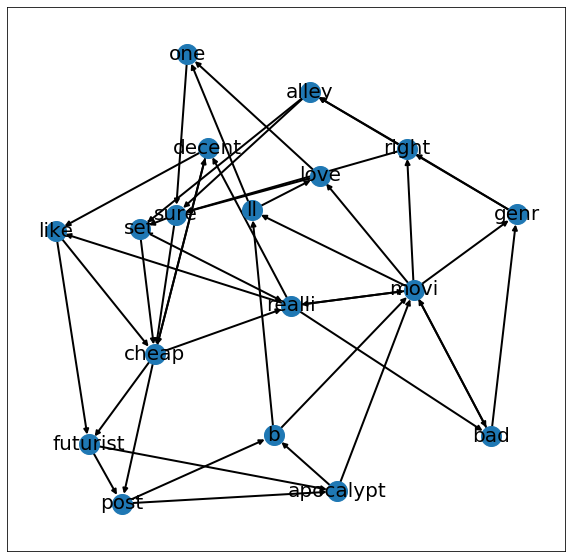

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def create_graph_of_words(doc, window_size):
    tokens = doc.split()
    n = len(tokens)
    G = nx.DiGraph()
    for i in range(n):
        for j in range(i+1,i+window_size):
            if j < n and tokens[i] != tokens[j]:
                G.add_edge(tokens[i], tokens[j])
    return G

G = create_graph_of_words(processed_data[0], 3)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

plt.figure(figsize=(10,10))
nx.draw_networkx(G, width=2, node_size=400, font_size=20)

We will next create a list of graph-of-words representations, each element of the list corresponding to the representation of one movie review.

<u>Tasks</u>:
- Create the graph-of-words representation of each movie review, and append it to the `Gs` list. Set the size of the sliding window equal to 3.

In [14]:
Gs = list()
window_size = 3

for doc in processed_data:
    G = create_graph_of_words(doc, 3)
    Gs.append(G)

We will next extract some features from our set of graphs and we will use these features to perform classification. Specifically, we will use the following three features: (i) nodes, (ii) paths of length 2, and (iii) triangles (i.e., directed cycles of length 3).

The code below extracts all these features from the list of graphs. The features are stored in the `features` dictionary which maps each feature to a unique integer value. Nodes are represented by their names, paths of length 2 are represented as tuples (node 1, node 2), and triangle are also represented as tuples (node 1, node 2, node 3).

In [15]:
features = dict()

for i,G in enumerate(Gs):
    for n1 in G.nodes():
        if n1 not in features:
            features[n1] = len(features)
        for n2 in G.successors(n1):
            if (n1,n2) not in features:
                features[(n1, n2)] = len(features)
            for n3 in G.successors(n2):
                if n1 != n3 and G.has_edge(n3, n1):
                    if (n1,n2,n3) not in features:
                        features[(n1, n2, n3)] = len(features)

We will next generate a document-feature matrix based on the features computed above.

<u>Tasks</u>:
- Fill in the entries of matrix `X` such that each row corresponds to the representation of a movie review based on the features defined above.
- Print the shape of the matrix.

In [16]:
from scipy.sparse import lil_matrix

X = lil_matrix((len(Gs), len(features)))

for i,G in enumerate(Gs):
    for n1 in G.nodes():
        X[i,features[n1]] += 1
        for n2 in G.successors(n1):
            X[i,features[(n1, n2)]] += 1
            for n3 in G.successors(n2):
                if n1 != n3 and G.has_edge(n3, n1):
                    X[i,features[(n1, n2, n3)]] += 1
                    
print("Shape of data matrix:", X.shape)

Shape of data matrix: (1959, 429621)


We will next use the matrix that we generated above to perform text categorization.

<u>Tasks</u>:
- Split the generated matrix into a trainign and a test set using the <a href='http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html'>`train_test_split()`</a> function of scikit-learn. Set the size of the test set equal to 40% of the size of the dataset. Set the seed used by the random number generator to 42.
- Train a <a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>`Logistic Regression`</a> classifier and use it to predict the class labels of the test instances.
- Compute the accuracy, precision, recall, and f1-score (use the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html'>`accuracy_score()`</a> and <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html'>`classification_report()`</a> functions of scikit-learn).

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, class_labels, test_size=0.4, random_state=42)

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print("Classification report:")
print(classification_report(y_test, y_pred))
print()
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8367346938775511

Classification report:
              precision    recall  f1-score   support

          -1       0.85      0.83      0.84       397
           1       0.83      0.84      0.84       387

    accuracy                           0.84       784
   macro avg       0.84      0.84      0.84       784
weighted avg       0.84      0.84      0.84       784


Confusion matrix:
[[329  68]
 [ 60 327]]


The function `create_graph_of_words()` that we defined above takes as input a single document and creates its graph-of-words representation. We can extract interesting insights from our dataset, if we generate a single graph for the whole dataset, and perform some analysis on it.

<u>Tasks</u>:
- Write a function that generates the graph-of-words representation of a corpus of documents.
- Use that function to build the graph-of-words representation of the whole corpus of movie reviews. Set the size of the sliding window equal to 3.
- Compute the node with the highest in-degree and out-degree (use the <a href='https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.DiGraph.in_degree.html'>`in_degree()`</a> and <a href='https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.DiGraph.out_degree.html#networkx.DiGraph.out_degree'>`out_degree()`</a> functions of NetworkX).
- Use the <a href='https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.k_core.html#networkx.algorithms.core.k_core'>`k_core()`</a> function of NetworkX to compute the main core of the graph.

In [18]:
def create_corpus_graph_of_words(docs, window_size):
    G = nx.DiGraph()
    
    for doc in docs:
        tokens = doc.split()
        n = len(tokens)
        for i in range(n):
            for j in range(i+1,i+window_size):
                if j < n and tokens[i] != tokens[j]:
                    G.add_edge(tokens[i], tokens[j])
    return G

G_corpus = create_corpus_graph_of_words(processed_data, 3)
print("Nodes:", G_corpus.number_of_nodes())
print("Edges:", G_corpus.number_of_edges())

Nodes: 17450
Edges: 361291


In [19]:
topn = 10

in_degs = list(G_corpus.in_degree())
in_deg_vals = [t[1] for t in in_degs]
idx = np.argsort(in_deg_vals)[-topn:]
print("Nodes with highest in-degrees:", [in_degs[i] for i in range(len(in_degs)) if i in idx])
print()

out_degs = list(G_corpus.out_degree())
out_deg_vals = [t[1] for t in out_degs]
idx = np.argsort(out_deg_vals)[-topn:]
print("Nodes with highest out-degrees:", [out_degs[i] for i in range(len(out_degs)) if i in idx])

Nodes with highest in-degrees: [('movi', 2275), ('like', 1360), ('one', 1842), ('get', 1140), ('time', 1149), ('even', 1058), ('film', 2438), ('stori', 1069), ('charact', 1078), ('make', 1208)]

Nodes with highest out-degrees: [('movi', 2319), ('like', 1769), ('one', 1666), ('get', 1149), ('time', 1287), ('see', 1169), ('film', 2490), ('stori', 1046), ('charact', 1036), ('make', 1070)]


In [20]:
print("Nodes in the main core:", nx.k_core(G_corpus).nodes())

Nodes in the main core: ['one', 'audienc', 'love', 'right', 'main', 'use', 'actual', 'fan', 'help', 'pretti', 'life', 'horror', 'two', 'believ', 'yet', 'everi', 'place', 'mani', 'worth', 'almost', 'cours', 'script', 'world', 'sinc', 'start', 'differ', 've', 'anoth', 'special', 'true', 'instead', 'version', 'disappoint', 'thing', 'coupl', 'doesn', 'even', 'goe', 'us', 'done', 'turn', '2', 'funni', 'guy', 'understand', 'cast', 'still', 'old', 'chang', 'girl', 'classic', 'tell', 'll', 'call', 'mayb', 'give', 'ever', 'minut', 'bit', 'great', 'watch', 'actor', 'let', 'comedi', 'money', 'kill', 'end', 'd', 'begin', 'music', 'better', 'realli', 'act', 'complet', 'read', 'make', 'job', 'like', 'littl', 'eye', 'idea', 'rather', 'follow', 'want', 'big', 'direct', 'anyth', 'everyth', 'kind', 'anyon', 'scene', 'man', 'mean', 'appear', 'made', 'rememb', 'keep', 'anim', 'know', 'action', 'problem', 'howev', 'line', 'never', 'short', 'director', 'would', 'tv', 'way', 'sens', 'leav', 'young', 'away', 